# Score de risque de récidive

## Importation des librairies

In [1]:
import numpy as np
import pandas as pd

import datetime
import scipy
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime

import os
import seaborn as sns
from sklearn.model_selection import train_test_split

from IPython.display import display
pd.options.display.max_columns = None

import missingno as msno


from pycaret.classification import *

## Importation des données 

In [2]:
# import pandas as pd
compas_scores_raw = pd.read_csv("./archive/compas-scores-raw.csv")
cox_violent_parsed = pd.read_csv("./archive/cox-violent-parsed.csv")
cox_violent_parsed_filt = pd.read_csv("./archive/cox-violent-parsed_filt.csv")
propublica_data_for_fairml = pd.read_csv("./archive/propublicaCompassRecividism_data_fairml.csv/propublica_data_for_fairml.csv")

## Analyse des données 

## 1. Analyse exploratoire des données 

#### Dimension des données

In [3]:
#Dimensions des dataSet
print("nombre de cas dans compas_scores_row est : ", compas_scores_raw.shape)
print("nombre de cas dans cox_violent_parsed est : ", cox_violent_parsed.shape)
print("nombre de cas dans cox_violent_parsed_filt est : ", cox_violent_parsed_filt.shape)
print("nombre de cas dans propublica_data_for_fairml est : ", propublica_data_for_fairml.shape)

nombre de cas dans compas_scores_row est :  (60843, 28)
nombre de cas dans cox_violent_parsed est :  (18316, 52)
nombre de cas dans cox_violent_parsed_filt est :  (18316, 40)
nombre de cas dans propublica_data_for_fairml est :  (6172, 12)


#### Nom des variables

In [4]:
#
compas_scores_raw.columns

Index(['Person_ID', 'AssessmentID', 'Case_ID', 'Agency_Text', 'LastName',
       'FirstName', 'MiddleName', 'Sex_Code_Text', 'Ethnic_Code_Text',
       'DateOfBirth', 'ScaleSet_ID', 'ScaleSet', 'AssessmentReason',
       'Language', 'LegalStatus', 'CustodyStatus', 'MaritalStatus',
       'Screening_Date', 'RecSupervisionLevel', 'RecSupervisionLevelText',
       'Scale_ID', 'DisplayText', 'RawScore', 'DecileScore', 'ScoreText',
       'AssessmentType', 'IsCompleted', 'IsDeleted'],
      dtype='object')

In [5]:
propublica_data_for_fairml.columns

Index(['Two_yr_Recidivism', 'Number_of_Priors', 'score_factor',
       'Age_Above_FourtyFive', 'Age_Below_TwentyFive', 'African_American',
       'Asian', 'Hispanic', 'Native_American', 'Other', 'Female',
       'Misdemeanor'],
      dtype='object')

#### Types des Variables

In [6]:
compas_scores_raw.info(); propublica_data_for_fairml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60843 entries, 0 to 60842
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person_ID                60843 non-null  int64  
 1   AssessmentID             60843 non-null  int64  
 2   Case_ID                  60843 non-null  int64  
 3   Agency_Text              60843 non-null  object 
 4   LastName                 60843 non-null  object 
 5   FirstName                60843 non-null  object 
 6   MiddleName               15648 non-null  object 
 7   Sex_Code_Text            60843 non-null  object 
 8   Ethnic_Code_Text         60843 non-null  object 
 9   DateOfBirth              60843 non-null  object 
 10  ScaleSet_ID              60843 non-null  int64  
 11  ScaleSet                 60843 non-null  object 
 12  AssessmentReason         60843 non-null  object 
 13  Language                 60843 non-null  object 
 14  LegalStatus           

#### Données manquantes

<Axes: >

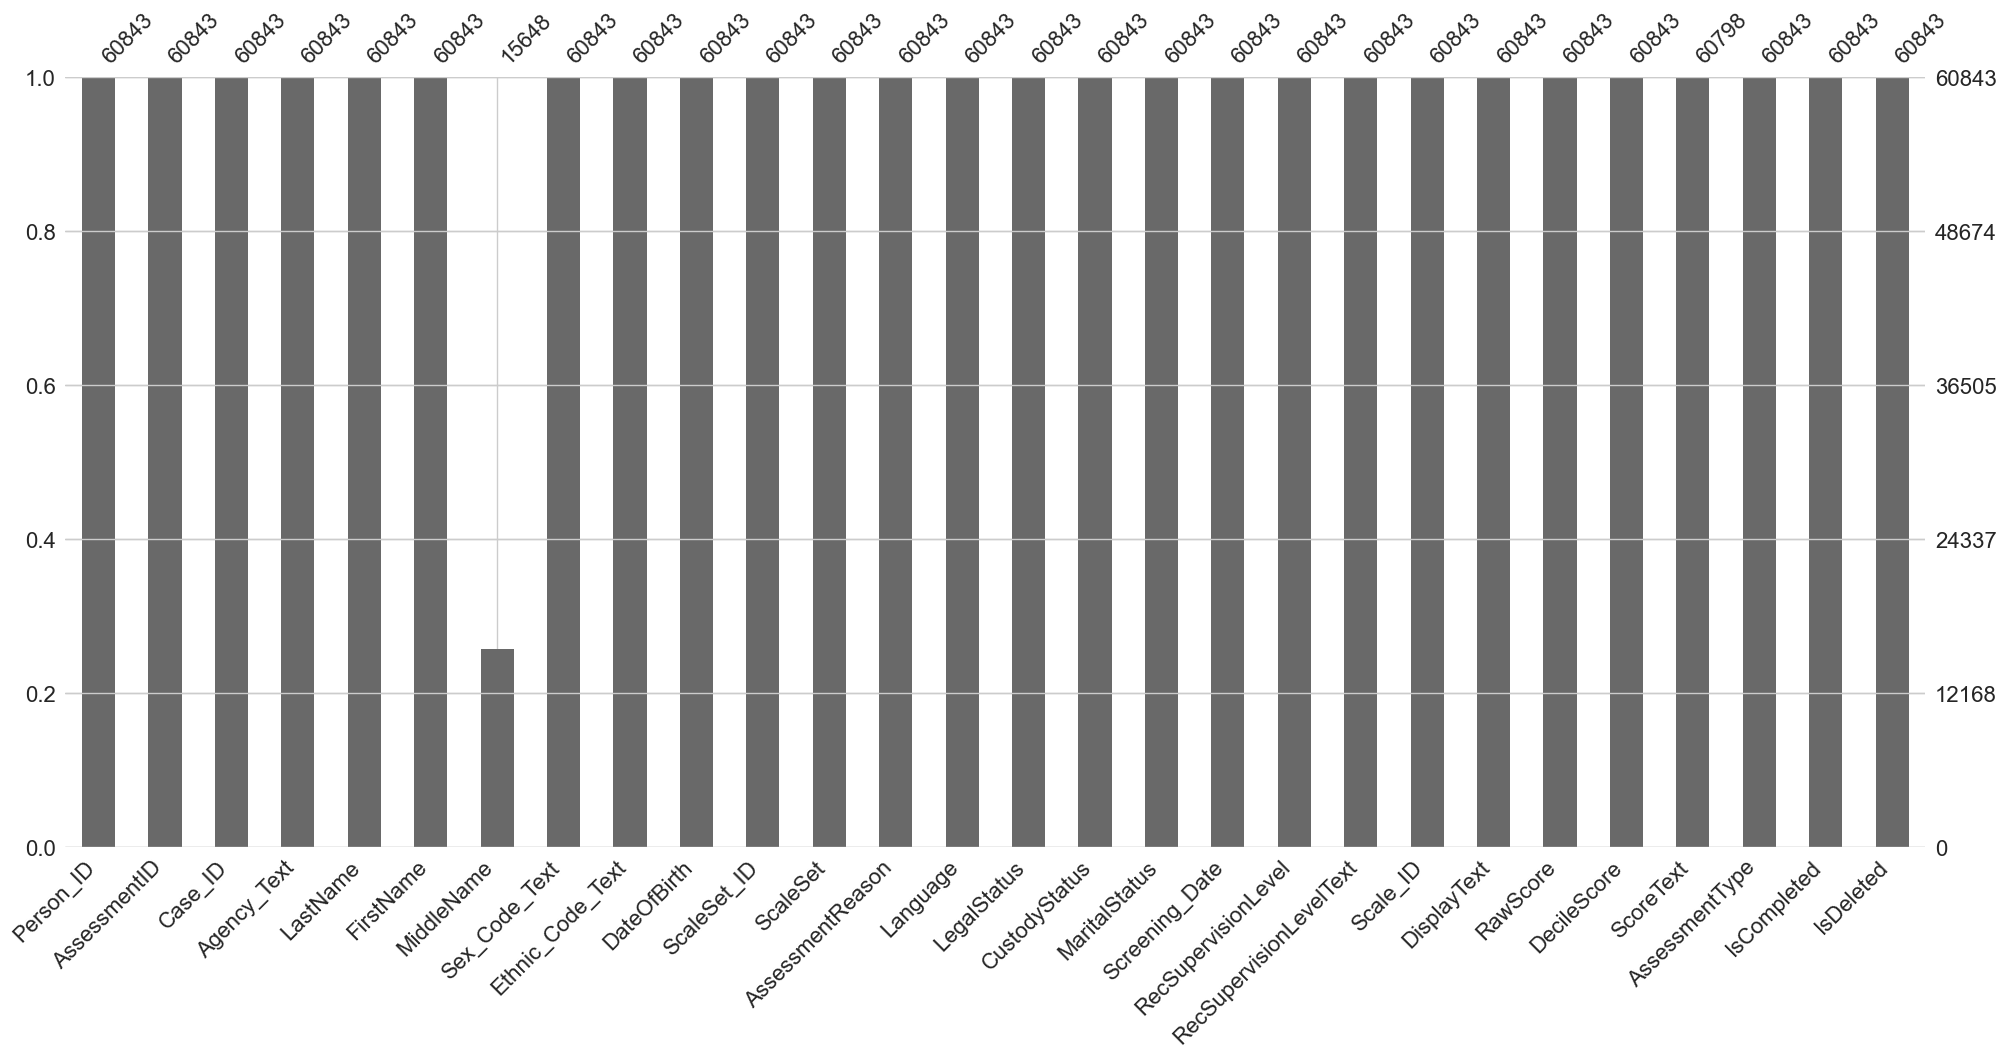

In [7]:
msno.bar(compas_scores_raw)

In [8]:
compas_scores_raw["ScoreText"].isnull().sum()

45

<Axes: >

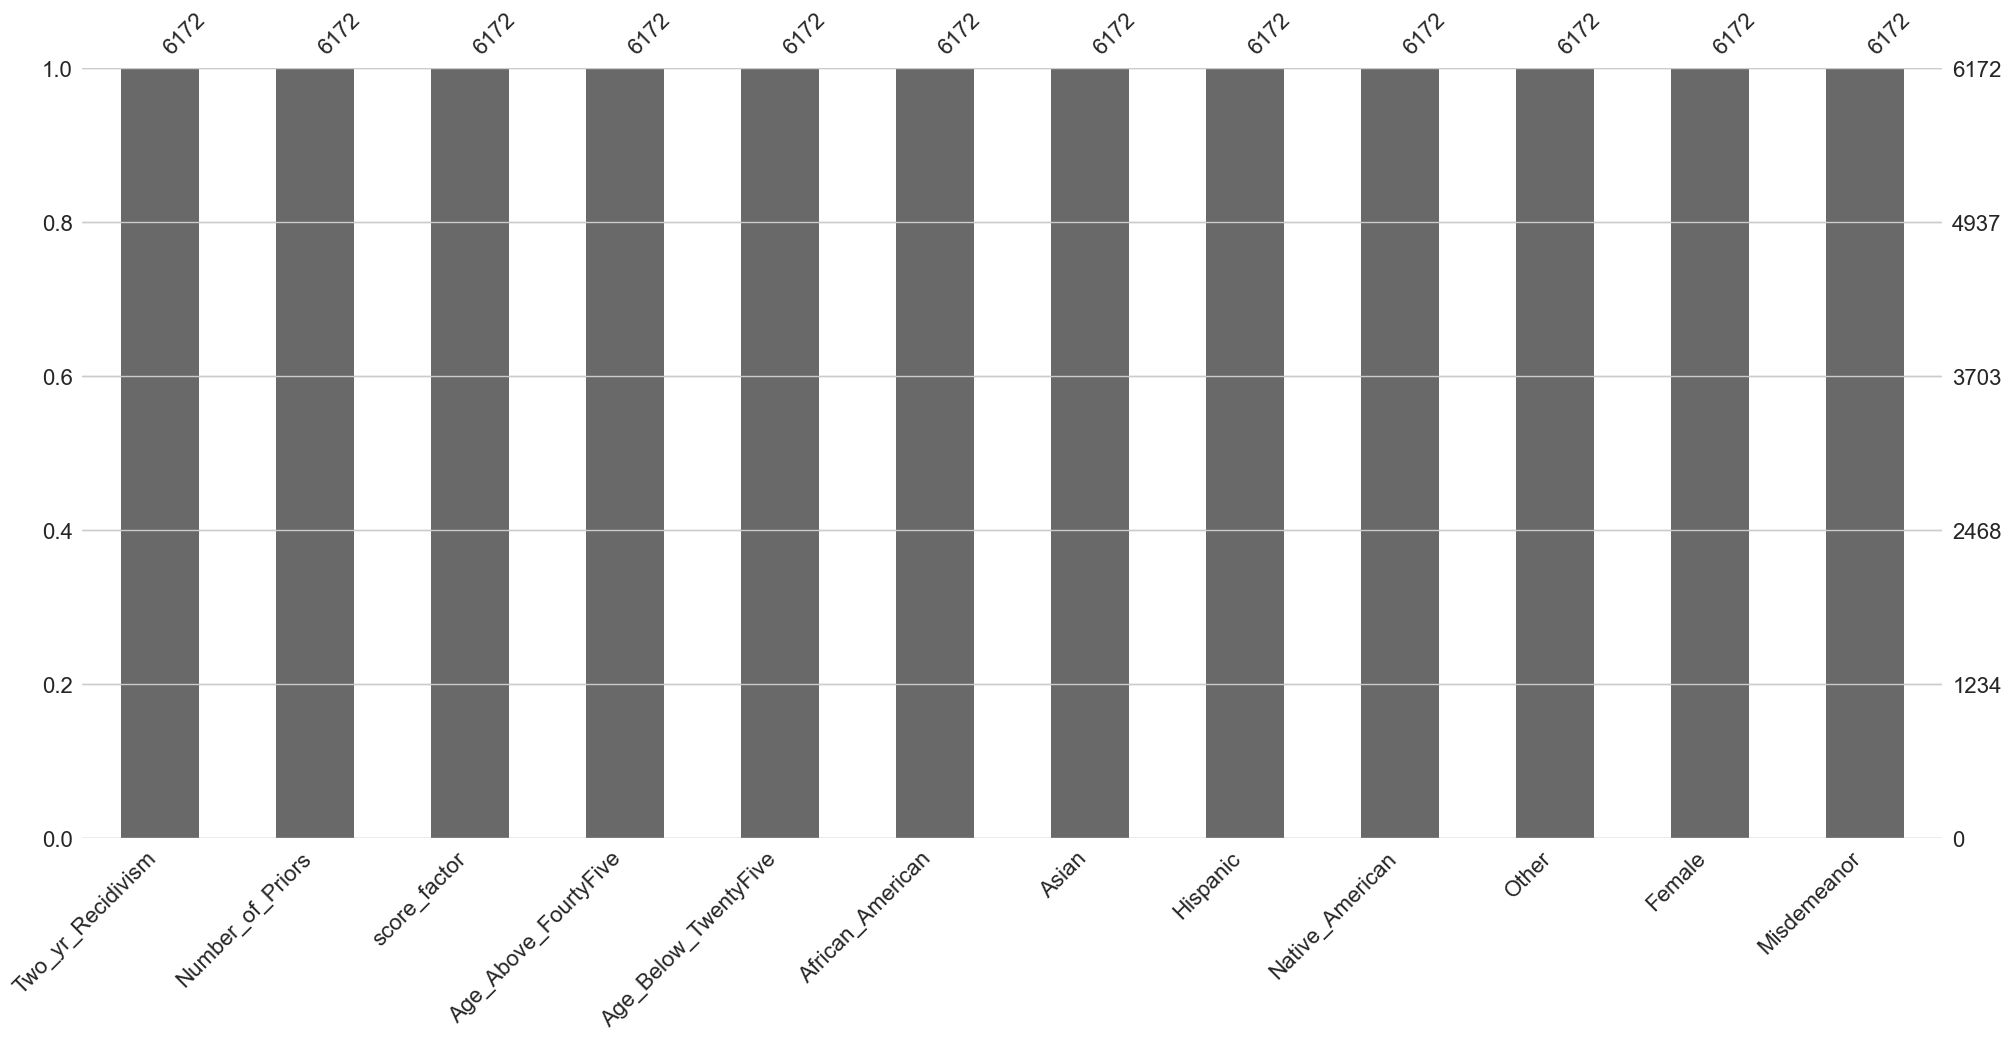

In [9]:
# visualizing it:
#msno.matrix(compas_scores_raw)
msno.bar(propublica_data_for_fairml)

#### Les histogrammes variables quantitatives de la dataSet propublica_data_for_fairml

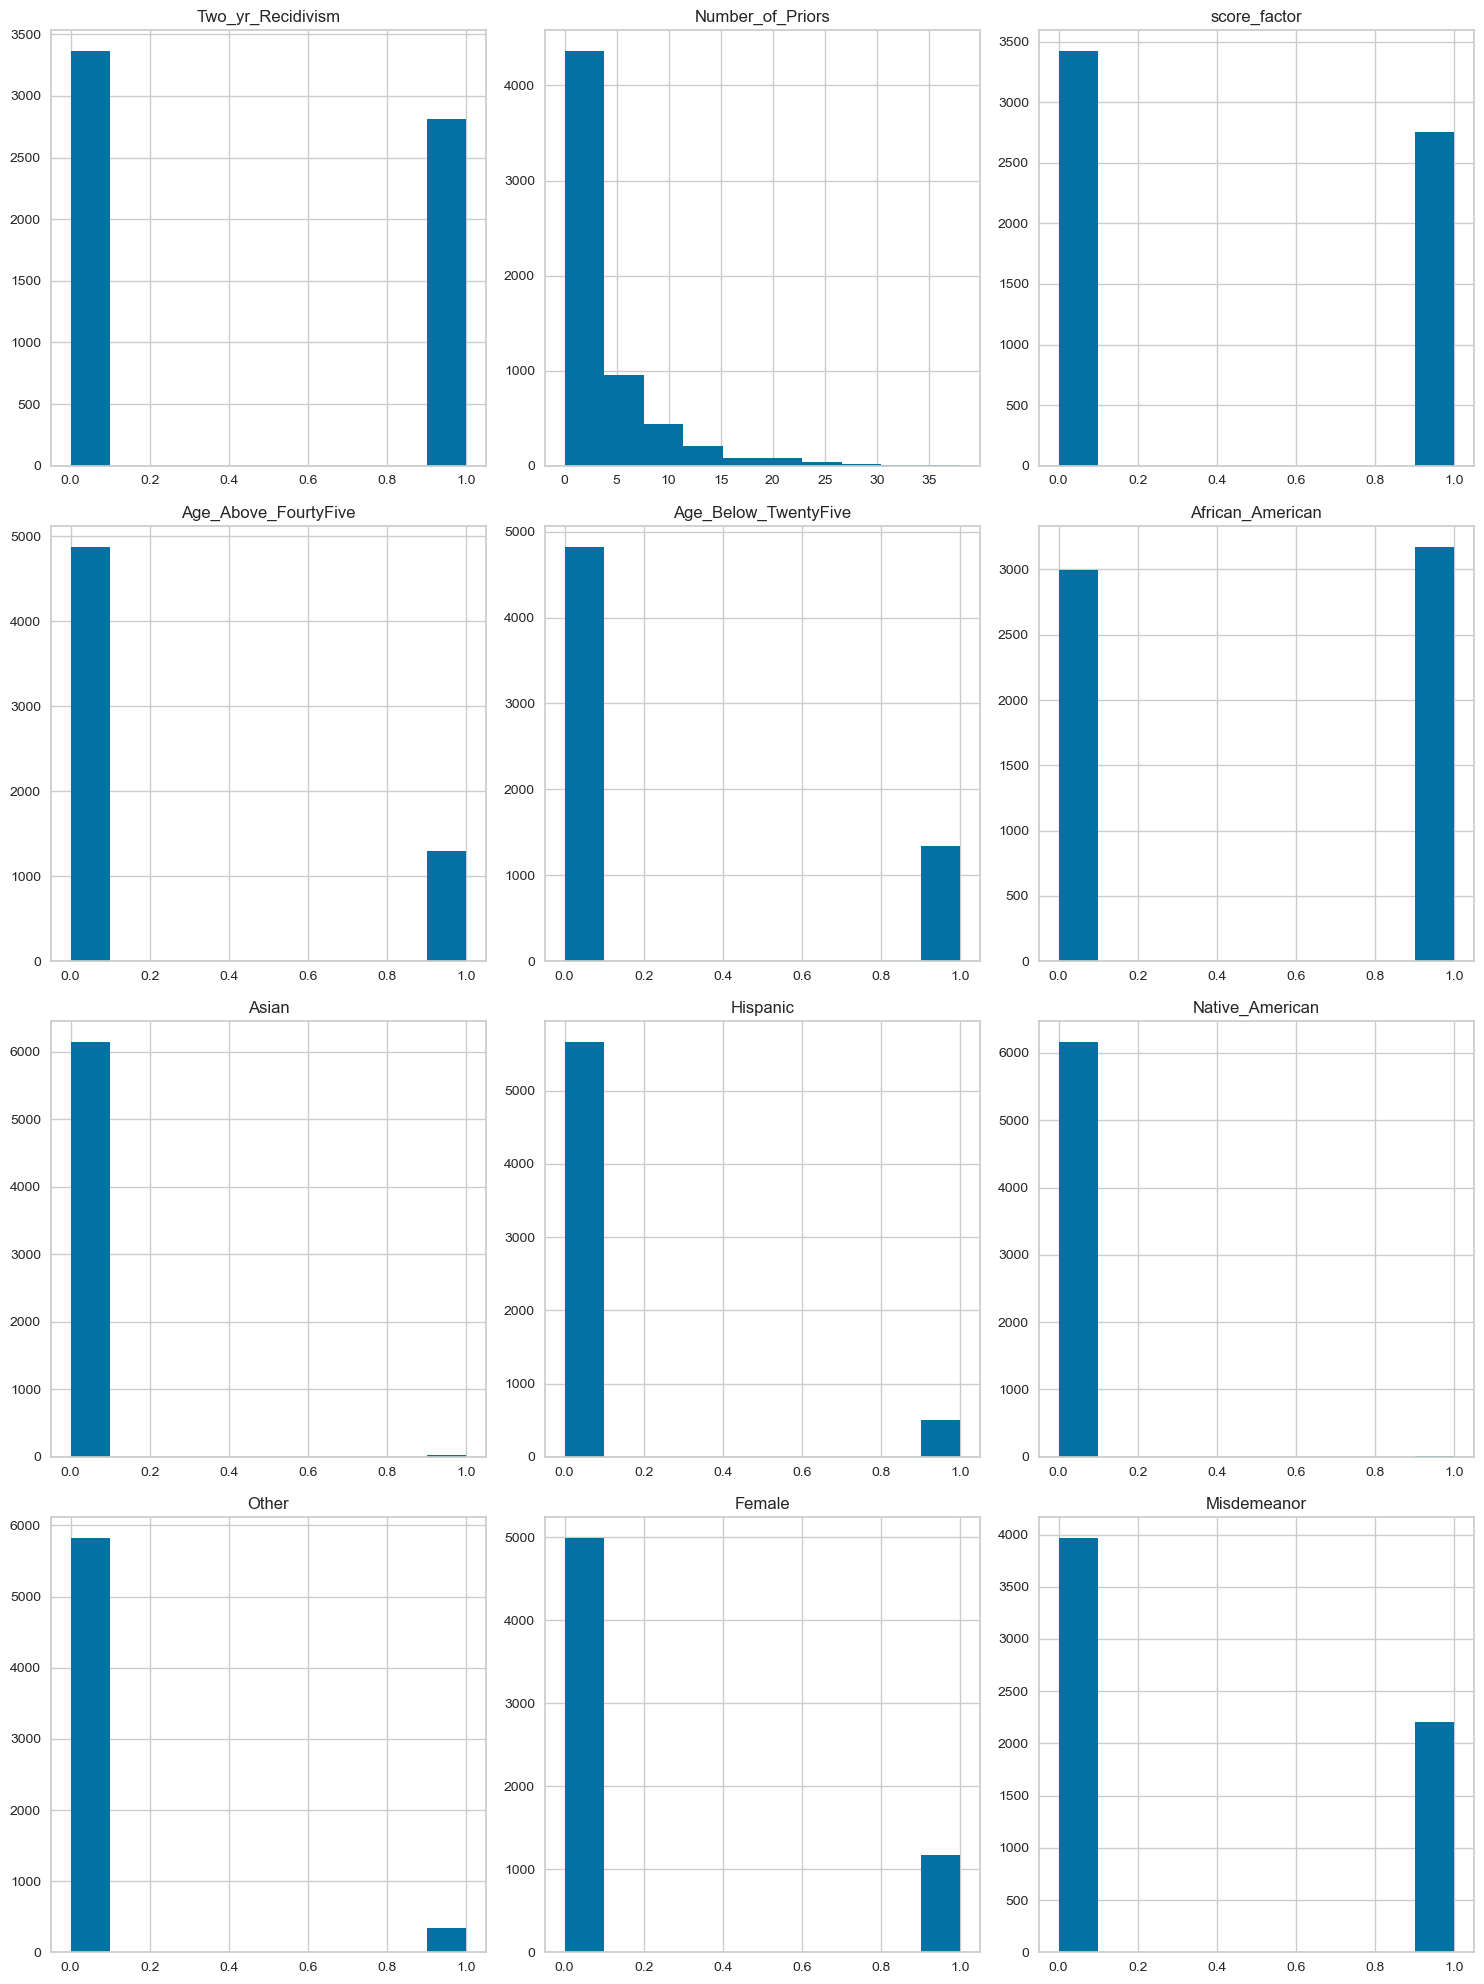

In [10]:
# Sélection des colonnes numériques
numeric_cols = propublica_data_for_fairml.select_dtypes(include=["float64", "int64"]).columns.tolist()

# Calcul du nombre de lignes et de colonnes nécessaires pour afficher les histogrammes
num_cols = len(numeric_cols)
num_rows = (num_cols - 1) // 3 + 1

# Tracé de l'histogramme de chaque colonne numérique
fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5*num_rows))

for i, col in enumerate(numeric_cols):
    row_idx = i // 3
    col_idx = i % 3
    ax = axes[row_idx, col_idx]
    ax.hist(propublica_data_for_fairml[col].dropna(), bins=10)
    ax.set_title(col)

# Suppression des axes inutiles
for i in range(num_cols, num_rows*3):
    row_idx = i // 3
    col_idx = i % 3
    fig.delaxes(axes[row_idx, col_idx])

# Ajustement des espacements entre les graphiques
fig.tight_layout()

plt.show()



#### Histogrammes des variables quantitatives CompasScoreRaw

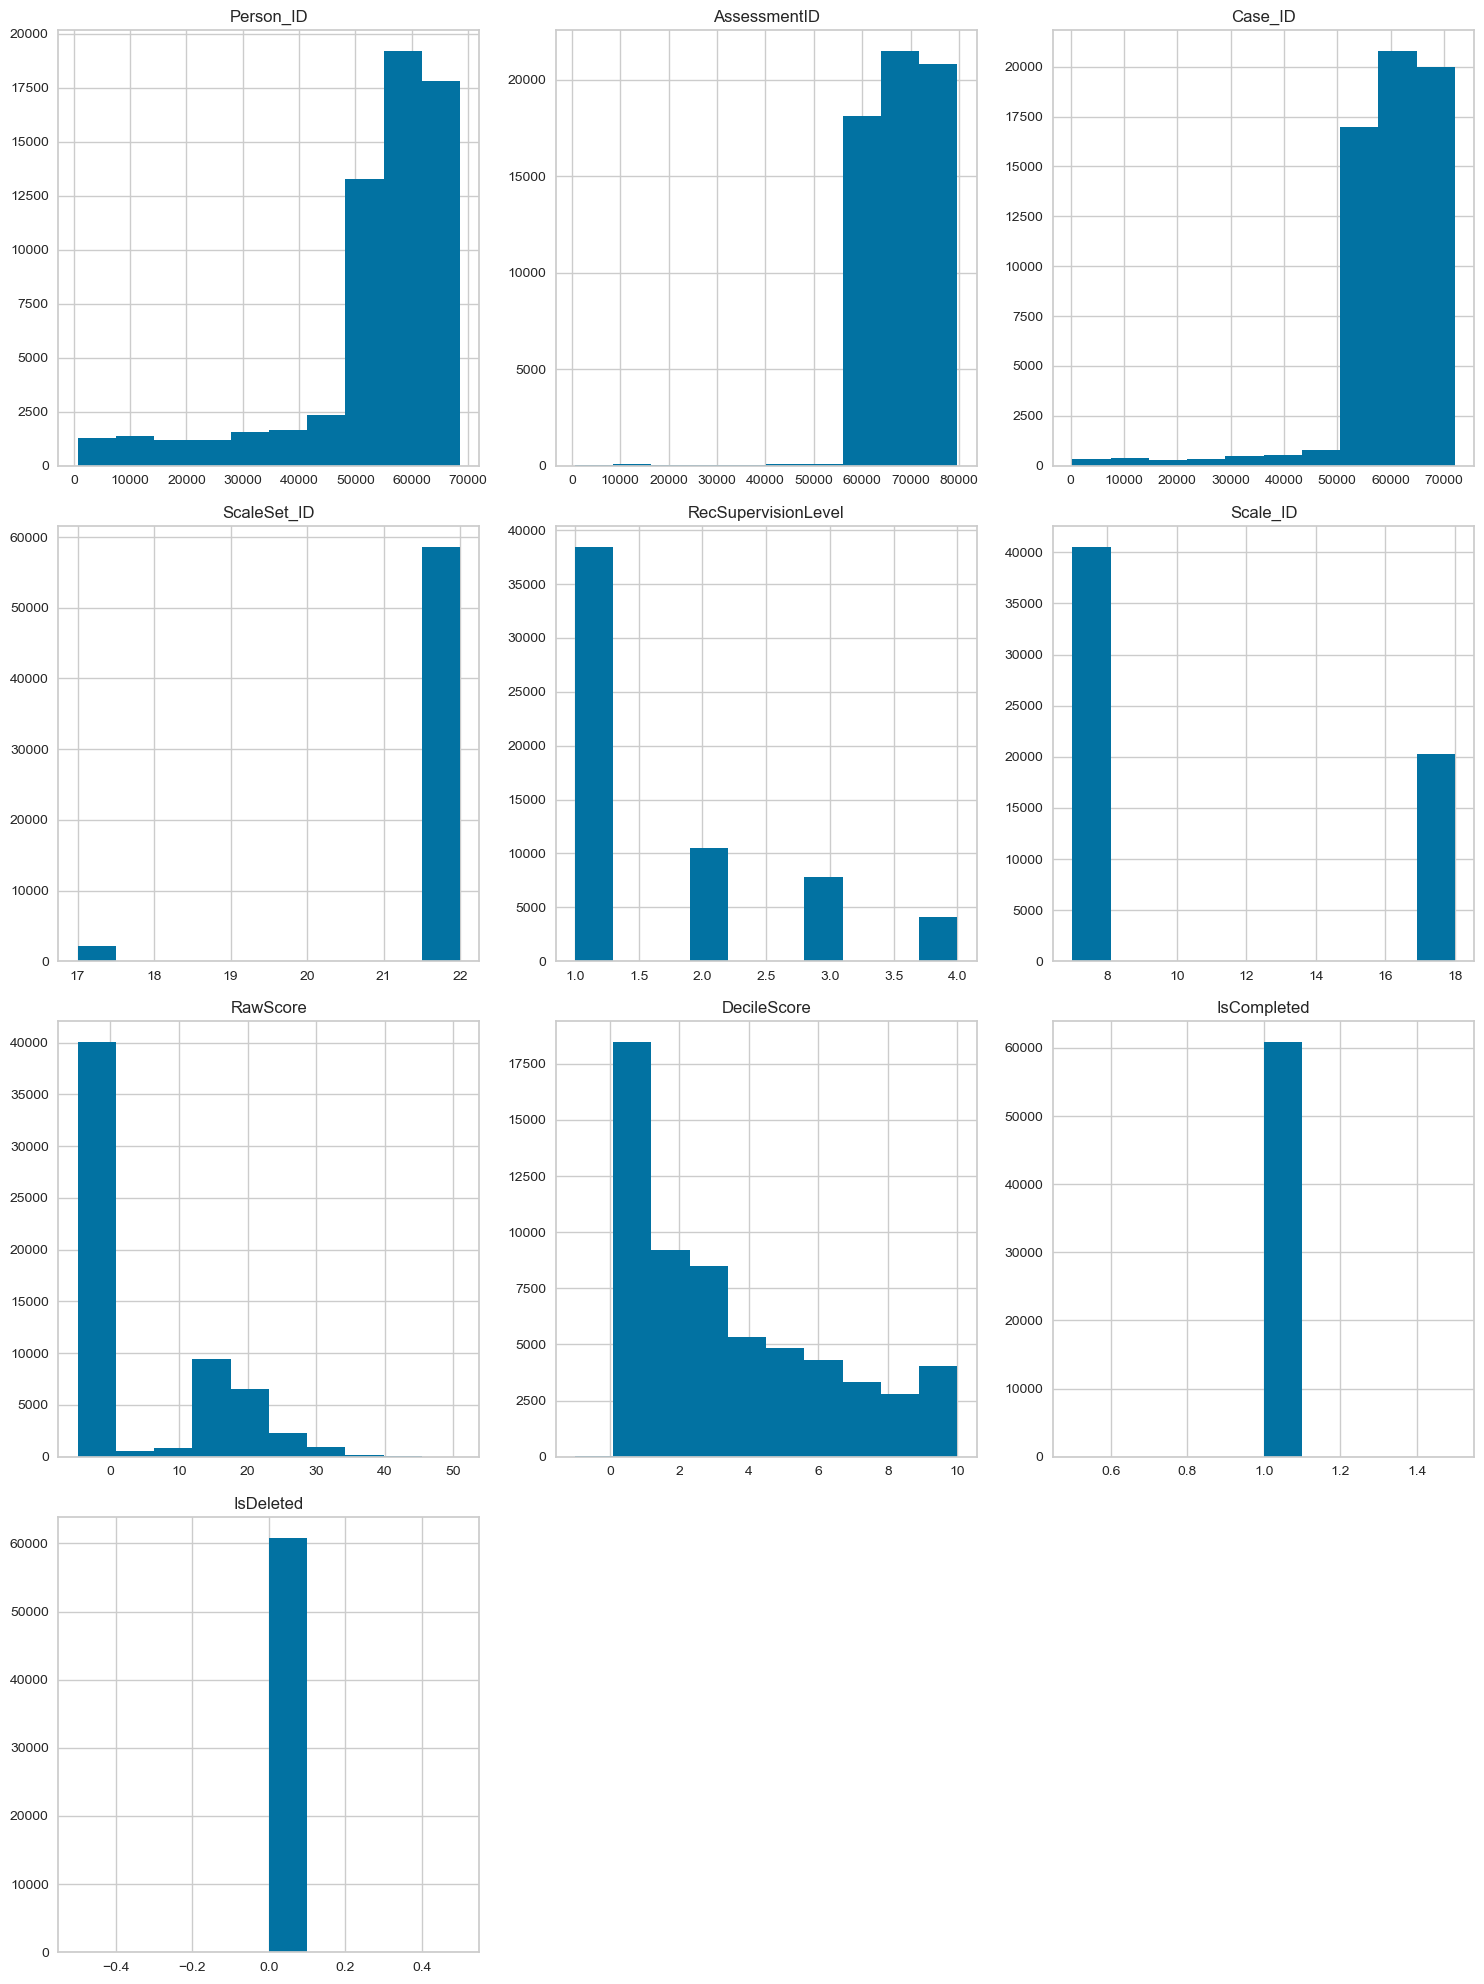

In [11]:
# Sélection des colonnes numériques
numeric_cols = compas_scores_raw.select_dtypes(include=["float64", "int64"]).columns.tolist()

# Calcul du nombre de lignes et de colonnes nécessaires pour afficher les histogrammes
num_cols = len(numeric_cols)
num_rows = (num_cols - 1) // 3 + 1

# Tracé de l'histogramme de chaque colonne numérique
fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5*num_rows))

for i, col in enumerate(numeric_cols):
    row_idx = i // 3
    col_idx = i % 3
    ax = axes[row_idx, col_idx]
    ax.hist(compas_scores_raw[col].dropna(), bins=10)
    ax.set_title(col)

# Suppression des axes inutiles
for i in range(num_cols, num_rows*3):
    row_idx = i // 3
    col_idx = i % 3
    fig.delaxes(axes[row_idx, col_idx])

# Ajustement des espacements entre les graphiques
fig.tight_layout()

plt.show()

#### Diagrammes en bandes des 

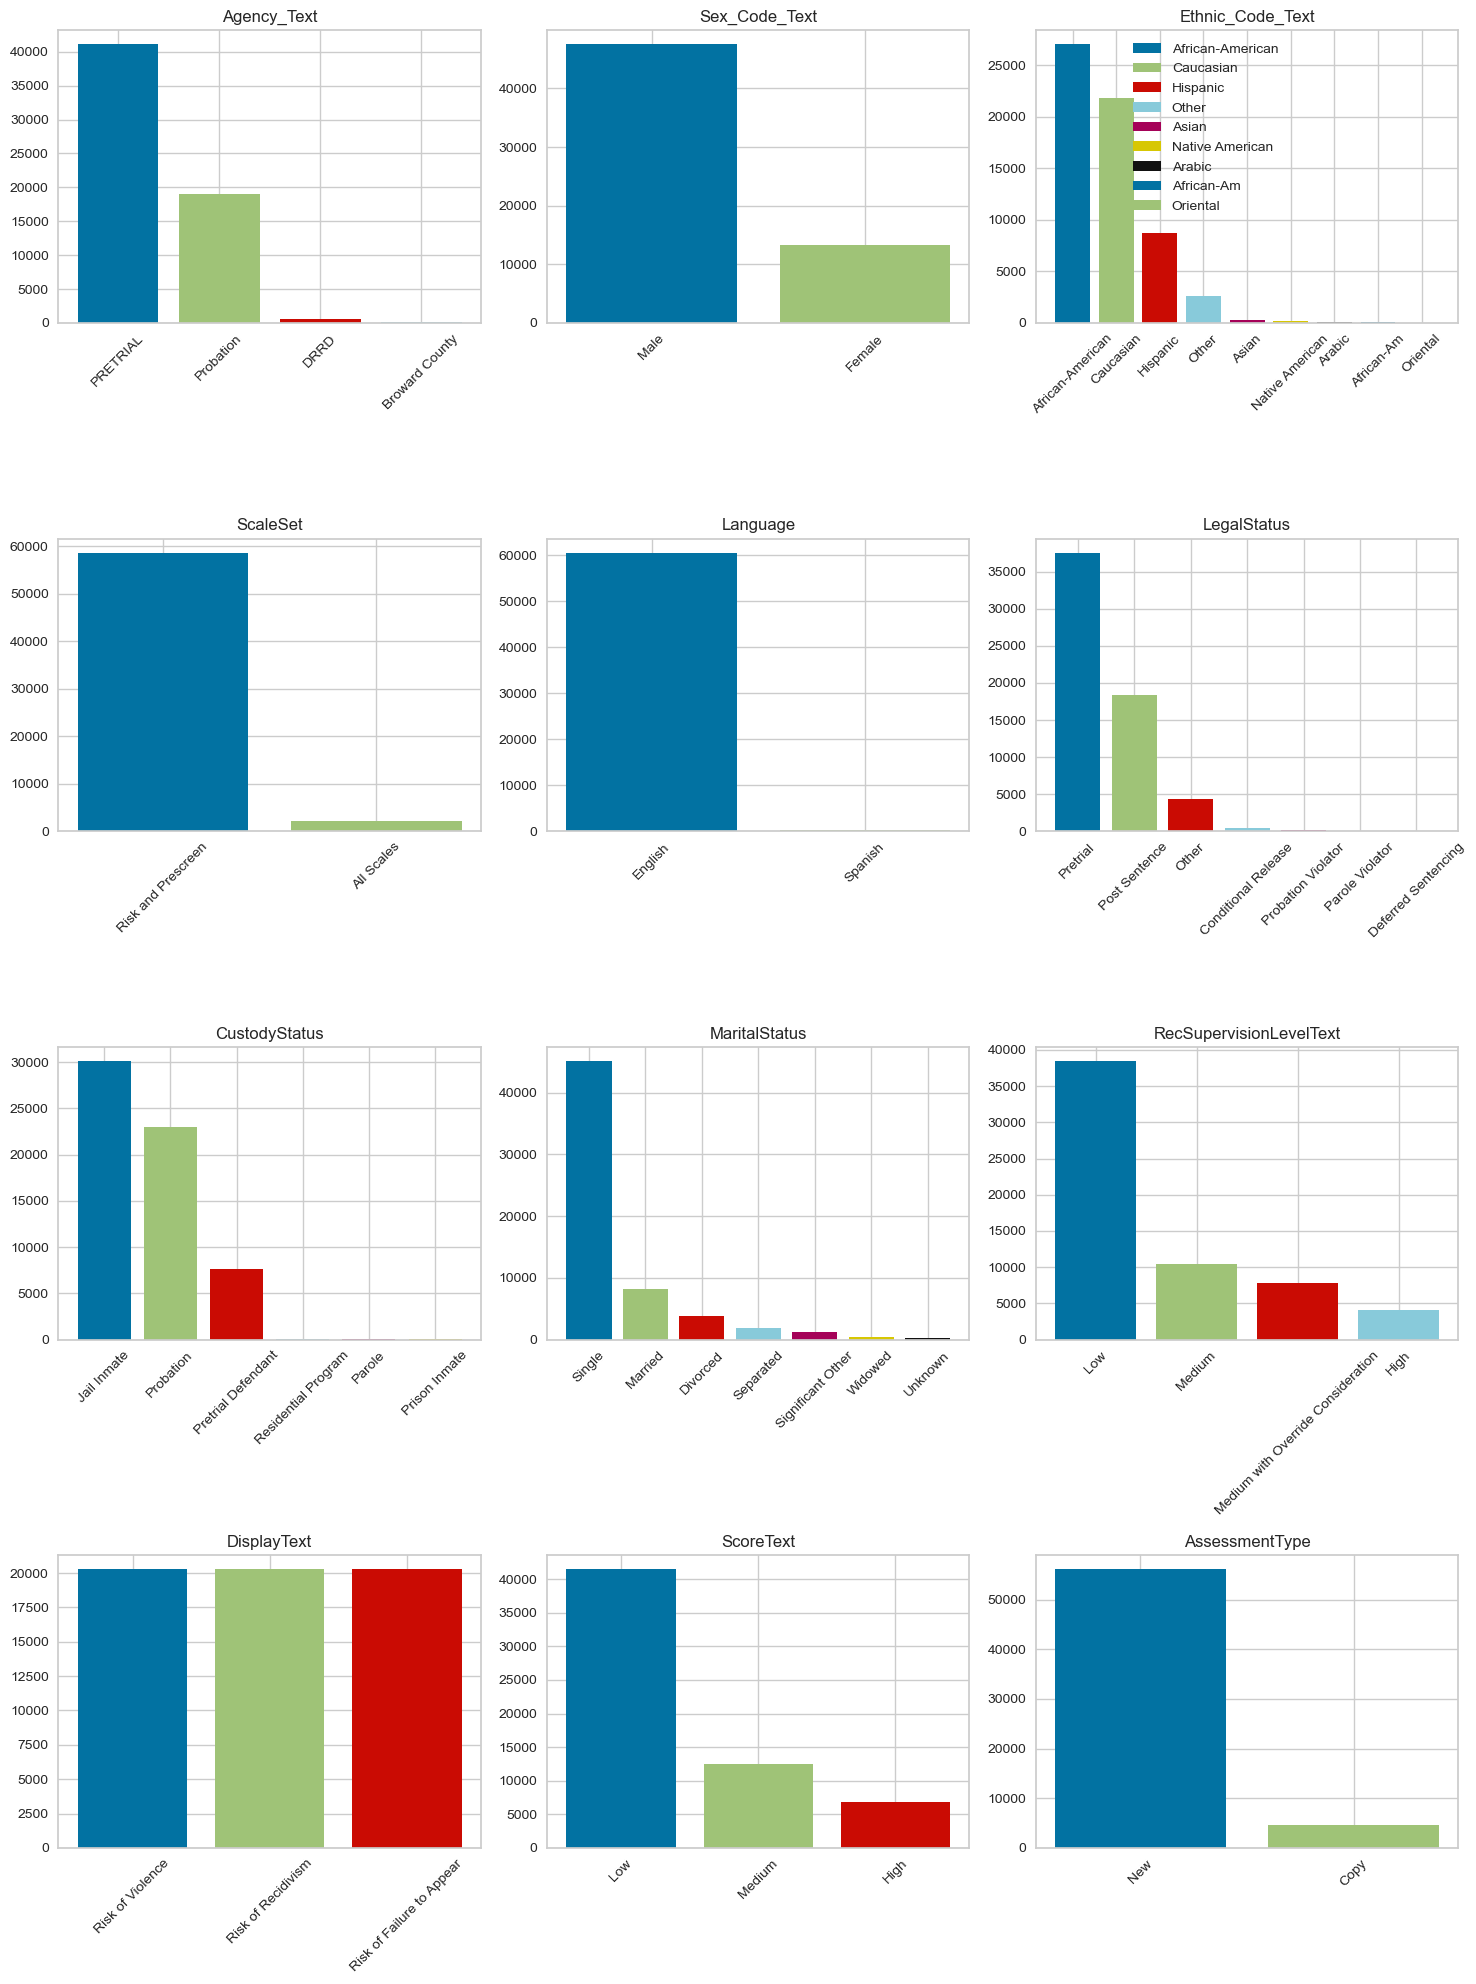

In [12]:
# Sélection des colonnes catégorielles
x= compas_scores_raw[['Agency_Text','Sex_Code_Text', 'Ethnic_Code_Text','ScaleSet',
       'Language', 'LegalStatus', 'CustodyStatus', 'MaritalStatus','RecSupervisionLevel', 
        'RecSupervisionLevelText','DisplayText', 'RawScore', 'DecileScore', 'ScoreText',
       'AssessmentType']]
categorical_cols = x.select_dtypes(include=["object"]).columns.tolist()

# Calcul du nombre de lignes et de colonnes nécessaires pour afficher les diagrammes en bande
num_cols = len(categorical_cols)
num_rows = (num_cols - 1) // 3 + 1

# Spécification des couleurs pour chaque catégorie
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Tracé du diagramme en bande pour chaque colonne catégorielle
fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5*num_rows))

for i, col in enumerate(categorical_cols):
    row_idx = i // 3
    col_idx = i % 3
    ax = axes[row_idx, col_idx]
    counts = x[col].value_counts()
    bars = ax.bar(counts.index, counts, color=colors[:len(counts)])
    ax.set_title(col)
    ax.tick_params(axis='x', rotation=45)
    # Ajout d'une légende pour les couleurs
    if len(counts) > len(colors):
        ax.legend(bars, counts.index, bbox_to_anchor=(0.2, 1), loc='upper left')

# Suppression des axes inutiles
for i in range(num_cols, num_rows*3):
    row_idx = i // 3
    col_idx = i % 3
    fig.delaxes(axes[row_idx, col_idx])

# Ajustement des espacements entre les graphiques
fig.tight_layout()

plt.show()


#### Traitement des données

In [13]:
#All texts that are African-American and African-Am should be the same.
compas_scores_raw["Ethnic_Code_Text"] = compas_scores_raw["Ethnic_Code_Text"].replace({"African-Am": "African-American"})

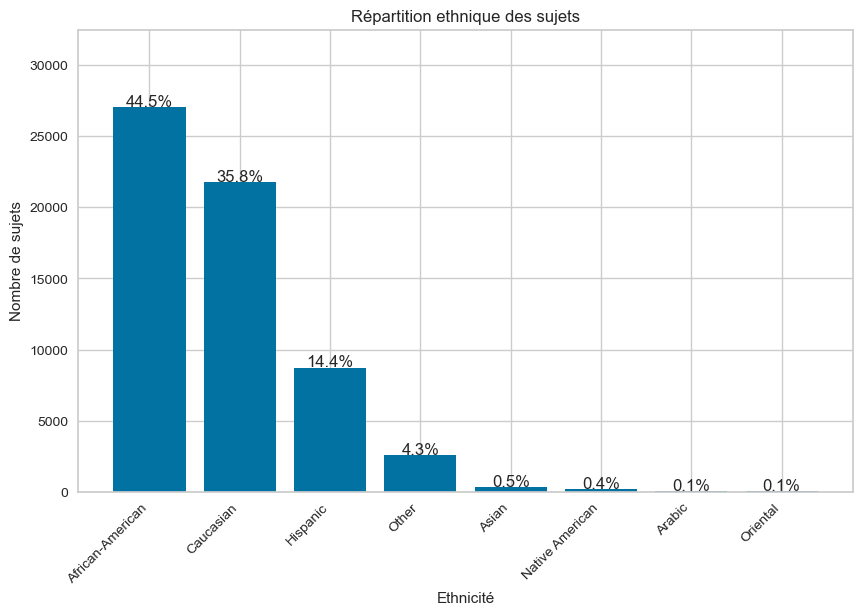

In [14]:
# Sélection de la colonne "Ethnic_Code_Text"
ethnic_col = compas_scores_raw["Ethnic_Code_Text"]

# Calcul des proportions de chaque modalité
counts = ethnic_col.value_counts()
percentages = counts / len(ethnic_col) * 100

# Création de la figure
fig, ax = plt.subplots(figsize=(10, 6))

# Création du diagramme en bande
bars = ax.bar(counts.index, counts)

# Ajout des pourcentages sur chaque barre
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 50, f"{percentages[i]:.1f}%", ha="center")

# Configuration de l'axe y
ax.set_ylim(0, max(counts) * 1.2)

# Configuration des étiquettes de l'axe x
plt.xticks(rotation=45, ha="right")

# Titre et étiquettes des axes
ax.set_title("Répartition ethnique des sujets")
ax.set_xlabel("Ethnicité")
ax.set_ylabel("Nombre de sujets")

plt.show()

In [15]:
compas_scores_raw = compas_scores_raw.drop(['MiddleName', 'IsCompleted', 'IsDeleted', 'AssessmentReason'], axis=1)
compas_scores_raw

,Person_ID,AssessmentID,Case_ID,Agency_Text,LastName,FirstName,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,ScaleSet_ID,ScaleSet,Language,LegalStatus,CustodyStatus,MaritalStatus,Screening_Date,RecSupervisionLevel,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType
0,50844,57167,51950,PRETRIAL,Fisher,Kevin,Male,Caucasian,12/05/92,22,Risk and Prescreen,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,7,Risk of Violence,-2.08,4,Low,New
1,50844,57167,51950,PRETRIAL,Fisher,Kevin,Male,Caucasian,12/05/92,22,Risk and Prescreen,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,8,Risk of Recidivism,-1.06,2,Low,New
2,50844,57167,51950,PRETRIAL,Fisher,Kevin,Male,Caucasian,12/05/92,22,Risk and Prescreen,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,18,Risk of Failure to Appear,15.00,1,Low,New
3,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,Male,Caucasian,09/16/84,22,Risk and Prescreen,English,Pretrial,Jail Inmate,Married,1/1/13 0:00,1,Low,7,Risk of Violence,-2.84,2,Low,New
4,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,Male,Caucasian,09/16/84,22,Risk and Prescreen,English,Pretrial,Jail Inmate,Married,1/1/13 0:00,1,Low,8,Risk of Recidivism,-1.50,1,Low,New
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60838,65667,79665,72038,Probation,West,James,Male,African-American,06/21/64,22,Risk and Prescreen,English,Pretrial,Jail Inmate,Single,12/31/14 0:00,3,Medium with Override Consideration,8,Risk of Recidivism,0.16,8,High,New
60839,65667,79665,72038,Probation,West,James,Male,African-American,06/21/64,22,Risk and Prescreen,English,Pretrial,Jail Inmate,Single,12/31/14 0:00,3,Medium with Override Consideration,18,Risk of Failure to Appear,35.00,10,High,New
60840,68603,79669,72042,PRETRIAL,Ryan,Michael,Male,Caucasian,02/06/85,22,Risk and Prescreen,English,Pretrial,Jail Inmate,Single,12/31/14 0:00,1,Low,7,Risk of Violence,-2.75,2,Low,New
60841,68603,79669,72042,PRETRIAL,Ryan,Michael,Male,Caucasian,02/06/85,22,Risk and Prescreen,English,Pretrial,Jail Inmate,Single,12/31/14 0:00,1,Low,8,Risk of Recidivism,-0.34,5,Medium,New


In [16]:
date_format = '%d/%m/%y'

date1_str = compas_scores_raw["DateOfBirth"][1]
date2_str = compas_scores_raw["Screening_Date"][1]

date1 = datetime.strptime(date1_str, '%d/%m/%y')
date2 = datetime.strptime(date2_str, '%d/%m/%y %H:%M')

age = (date2 - date1).days // 365

In [17]:
# Définition de la fonction qui calcule l'âge en années
def dateOfBirthTransform(P,G):
    
    formatting = "%m/%d/%Y"
    x = P.split("/")
    if x[-2] == "0":
        x[-1] = "20" + x[-1][-2:]
    else:
        x[-1] = "19" + x[-1][-2:] # remplace les deux derniers caractères par "19" + les deux derniers caractères
    date_string = "/".join(x)
#     print(x)
    date2 = datetime.strptime(G, '%m/%d/%y %H:%M')
    date_object = datetime.strptime(date_string, formatting)

    
    age = (date2 - date_object).days // 365
#     print("Age:", age)
    return int(age)
# Application de la fonction à chaque ligne du dataframe
#compas_scores_raw["Age"] = compas_scores_raw.apply(dateOfBirthTransform, axis=1)
compas_scores_raw['years']=compas_scores_raw.apply(lambda row: dateOfBirthTransform(row["DateOfBirth"], row["Screening_Date"]), axis=1)

In [18]:
# date_of_birth_str = compas_scores_raw["DateOfBirth"]
# screening_date_str = compas_scores_raw["Screening_Date"]
    
#     # Conversion des dates en objets datetime
# birth_date = datetime.strptime(date_of_birth_str, '%m/%d/%y')
# screening_date = datetime.strptime(screening_date_str, '%m/%d/%y %H:%M')
    
#     # Ajout d'une condition pour les années avant 1980
# if birth_date.year < 80:
#     birth_date = birth_date.replace(year=birth_date.year + 1900)
# else:
#     birth_date = birth_date.replace(year=birth_date.year + 2000)
    
#     # Calcul de l'âge et mise à jour du dataframe
# age = (screening_date - birth_date).days // 365
# compas_scores_raw.loc[compas_scores_raw["id"] == id, "age"] = age


In [19]:
compas_scores_raw[compas_scores_raw["years"]<18]

,Person_ID,AssessmentID,Case_ID,Agency_Text,LastName,FirstName,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,ScaleSet_ID,ScaleSet,Language,LegalStatus,CustodyStatus,MaritalStatus,Screening_Date,RecSupervisionLevel,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType,years
519,50984,57364,52124,PRETRIAL,GREENE,BAILEY,Female,Caucasian,04/22/96,22,Risk and Prescreen,English,Pretrial,Pretrial Defendant,Single,1/7/13 0:00,3,Medium with Override Consideration,7,Risk of Violence,-1.23,8,High,New,16
520,50984,57364,52124,PRETRIAL,GREENE,BAILEY,Female,Caucasian,04/22/96,22,Risk and Prescreen,English,Pretrial,Pretrial Defendant,Single,1/7/13 0:00,3,Medium with Override Consideration,8,Risk of Recidivism,-0.44,6,Medium,New,16
521,50984,57364,52124,PRETRIAL,GREENE,BAILEY,Female,Caucasian,04/22/96,22,Risk and Prescreen,English,Pretrial,Pretrial Defendant,Single,1/7/13 0:00,3,Medium with Override Consideration,18,Risk of Failure to Appear,11.00,1,Low,New,16
3777,51947,58550,53199,Probation,HENRY,D'AUNDRE,Male,African-American,06/09/95,22,Risk and Prescreen,English,Pretrial,Pretrial Defendant,Single,2/7/13 0:00,2,Medium,7,Risk of Violence,-1.56,6,Medium,New,17
3778,51947,58550,53199,Probation,HENRY,D'AUNDRE,Male,African-American,06/09/95,22,Risk and Prescreen,English,Pretrial,Pretrial Defendant,Single,2/7/13 0:00,2,Medium,8,Risk of Recidivism,-0.26,6,Medium,New,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52051,66001,76382,69145,PRETRIAL,PITTS,JERRON,Male,African-American,07/22/97,22,Risk and Prescreen,English,Pretrial,Jail Inmate,Single,9/4/14 0:00,3,Medium with Override Consideration,8,Risk of Recidivism,0.39,9,High,New,17
52052,66001,76382,69145,PRETRIAL,PITTS,JERRON,Male,African-American,07/22/97,22,Risk and Prescreen,English,Pretrial,Jail Inmate,Single,9/4/14 0:00,3,Medium with Override Consideration,18,Risk of Failure to Appear,17.00,2,Low,New,17
56844,67384,78213,70779,PRETRIAL,Messadra,Oscar,Male,Hispanic,12/06/96,22,Risk and Prescreen,English,Pretrial,Jail Inmate,Divorced,11/2/14 0:00,2,Medium,7,Risk of Violence,-1.38,7,Medium,New,17
56845,67384,78213,70779,PRETRIAL,Messadra,Oscar,Male,Hispanic,12/06/96,22,Risk and Prescreen,English,Pretrial,Jail Inmate,Divorced,11/2/14 0:00,2,Medium,8,Risk of Recidivism,-0.49,5,Medium,New,17


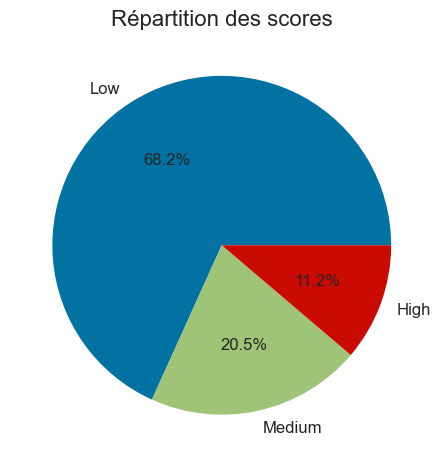

In [20]:
ethnic_counts = compas_scores_raw['ScoreText'].value_counts()

plt.pie(ethnic_counts, labels=ethnic_counts.index, autopct=lambda pct: "{:.1f}%".format(pct), textprops={'fontsize': 12})

plt.title("Répartition des scores", fontsize=16)

plt.show()

In [21]:
compas_scores_raw.shape

(60843, 25)

#### Analyse bivariées

Ici nous voulons visualiser la répartirion de la variables DecileScore sur les variables qualitatives

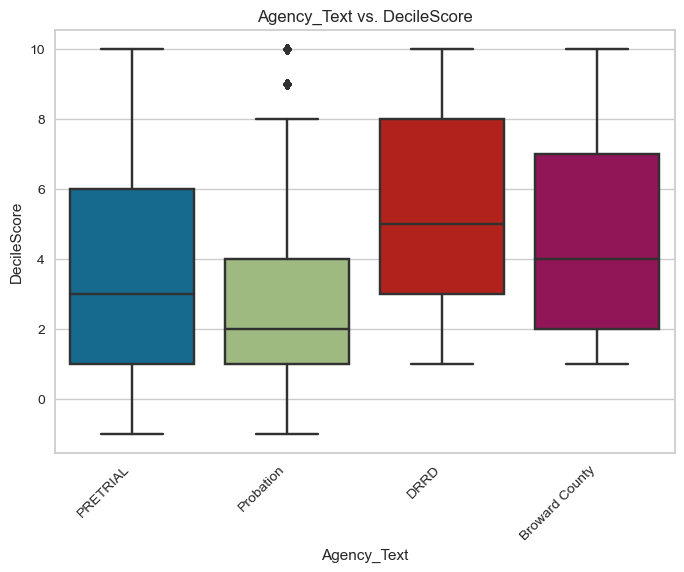

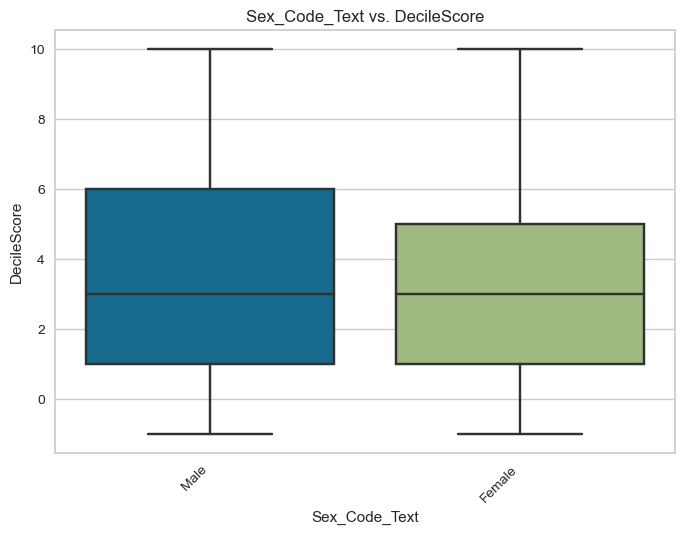

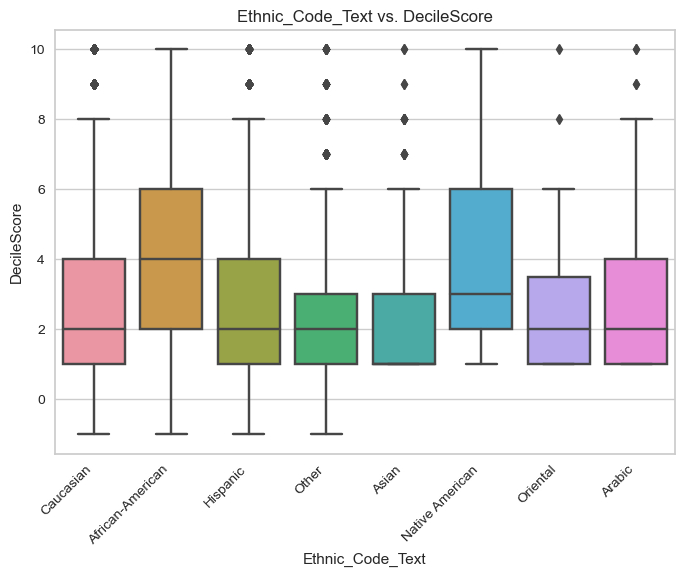

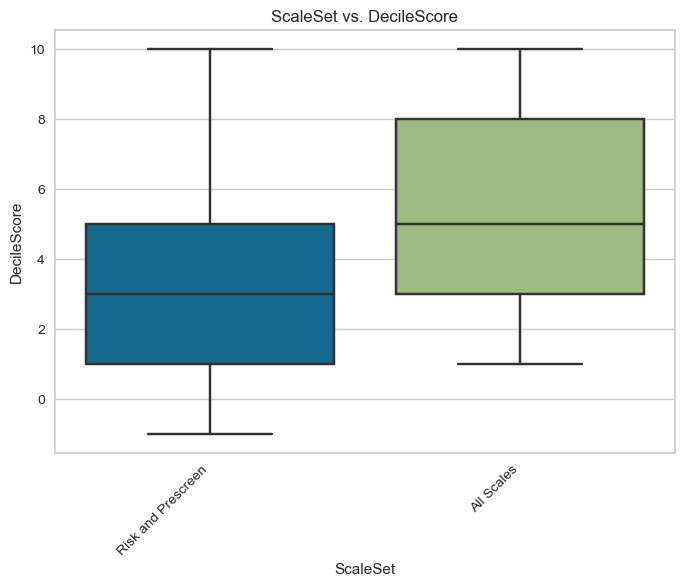

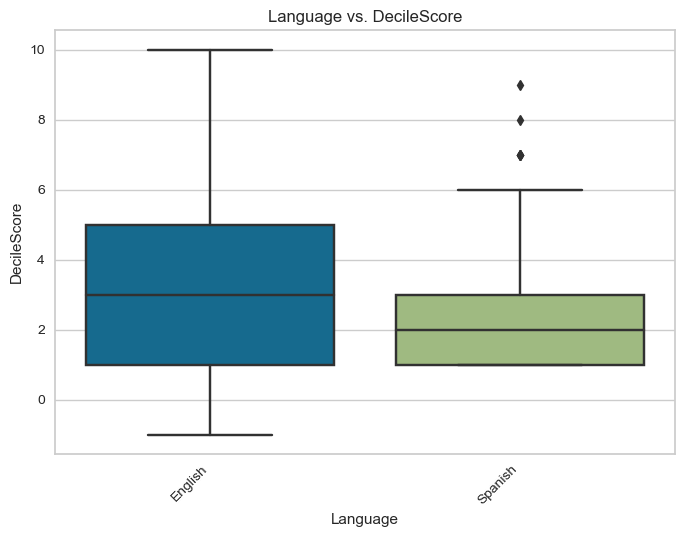

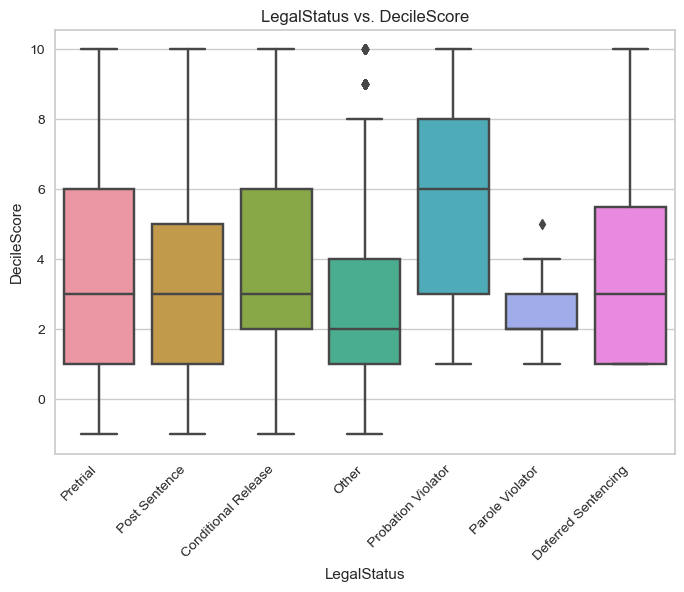

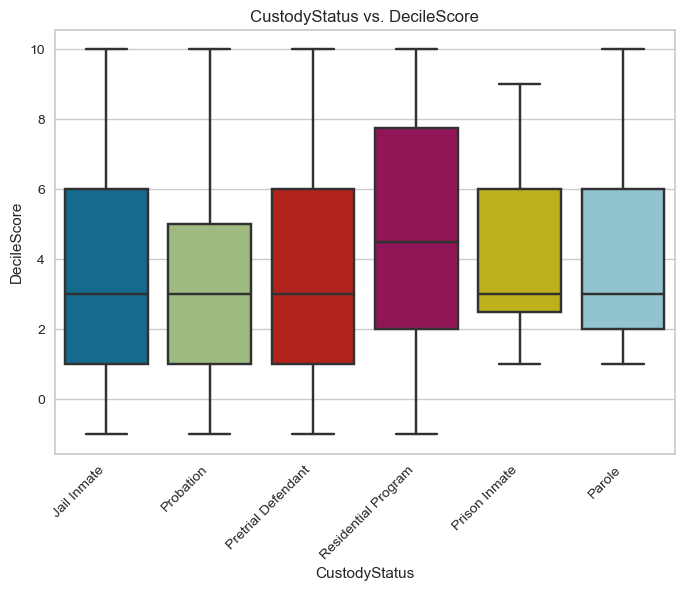

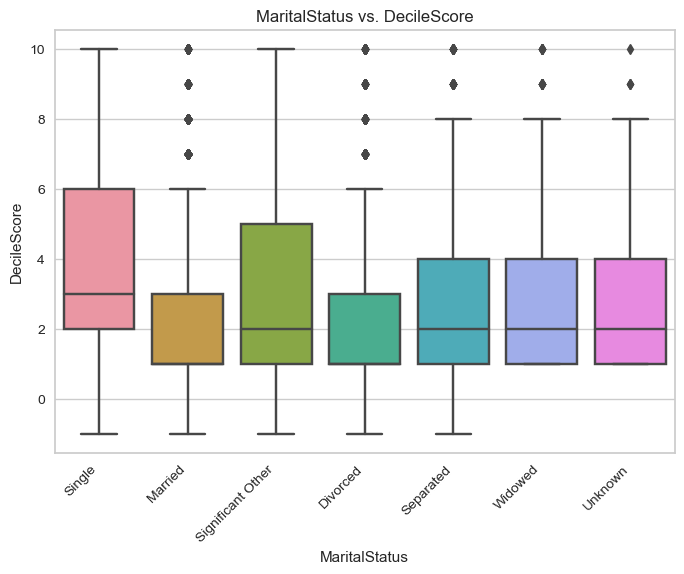

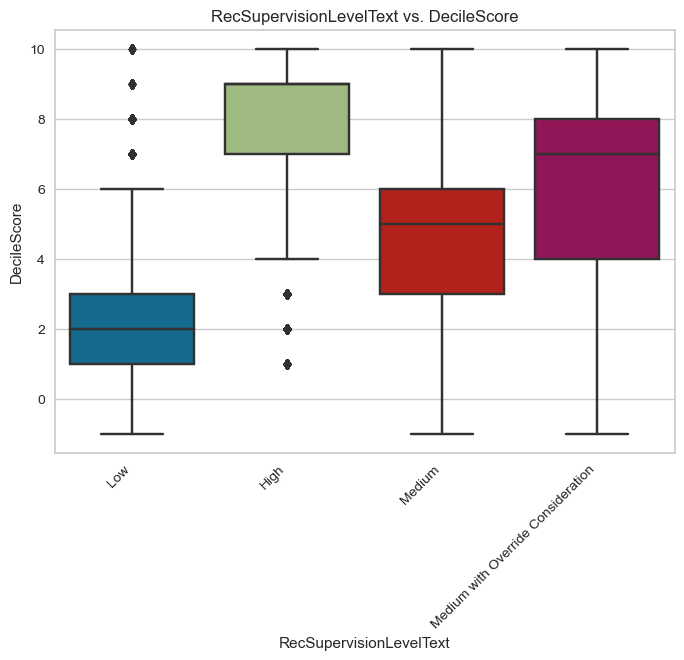

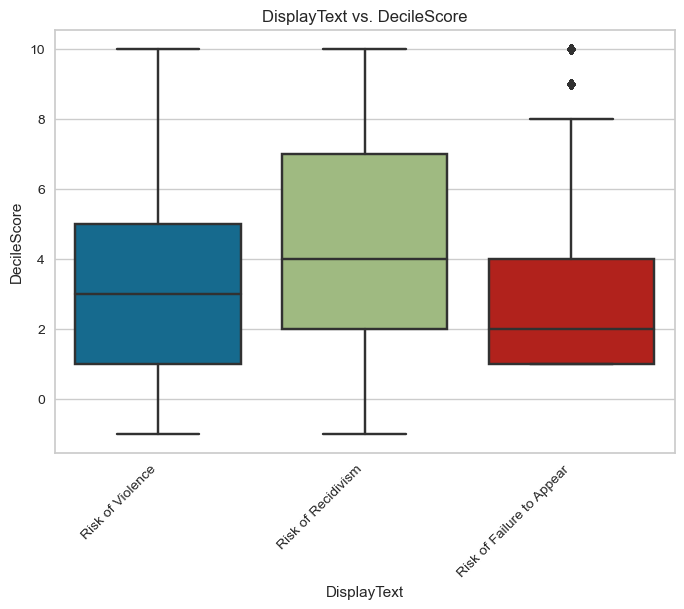

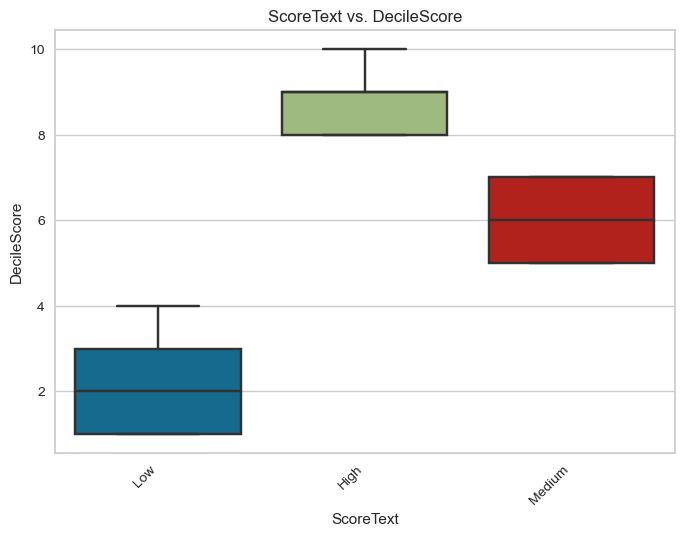

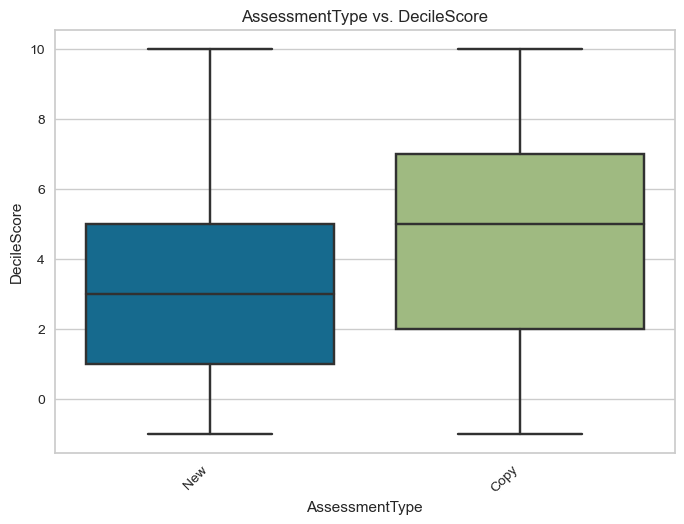

In [22]:
# Sélection des colonnes quantitatives
quant_cols = compas_scores_raw[['DecileScore']].select_dtypes(include=["float64", "int64"]).columns.tolist()

# Sélection des colonnes catégorielles
cat_cols = compas_scores_raw[['Agency_Text','Sex_Code_Text', 'Ethnic_Code_Text','ScaleSet',
       'Language', 'LegalStatus', 'CustodyStatus', 'MaritalStatus','RecSupervisionLevel', 
        'RecSupervisionLevelText','DisplayText', 'RawScore', 'DecileScore', 'ScoreText',
       'AssessmentType']].select_dtypes(include=["object"]).columns.tolist()

# Affichage des diagrammes en boîte pour chaque variable quantitative en fonction de chaque variable catégorielle
for col in cat_cols:
    for quant_col in quant_cols:
        sns.boxplot(x=col, y=quant_col, data=compas_scores_raw)
        # Configuration des étiquettes de l'axe x
        plt.xticks(rotation=45, ha="right")
        plt.title(col + ' vs. ' + quant_col)
        plt.show()


#### Diagramme en baton

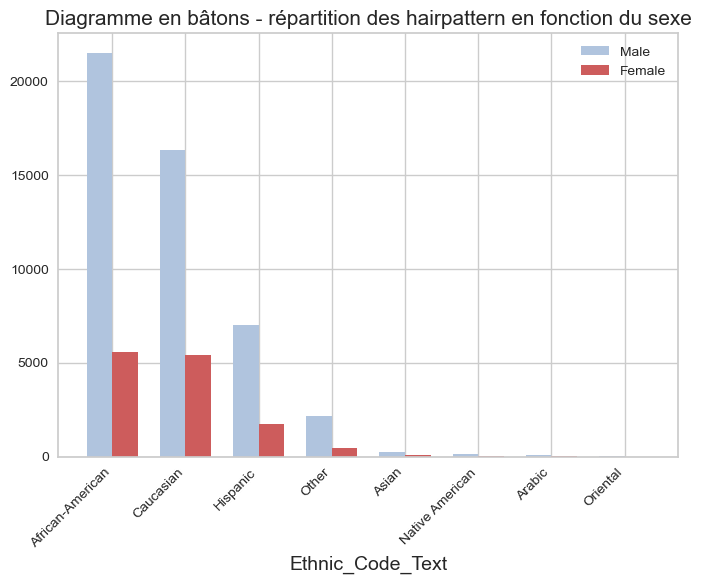

In [23]:
# Création du groupe "sex", et décompte des individus de chaque sous-grouê (male, female)
g = compas_scores_raw.groupby('Sex_Code_Text')
c_female = g.get_group('Female')['Ethnic_Code_Text'].value_counts()
c_male = g.get_group('Male')['Ethnic_Code_Text'].value_counts()

# On extrait les noms des différents hairpattern et des différents sexes
hairpat = compas_scores_raw['Ethnic_Code_Text'].value_counts().index
gender = compas_scores_raw['Sex_Code_Text'].value_counts().index
pos = np.arange(len(hairpat))
width = 0.35  # épaisseur de chaque bâton

# Création du diagramme en bâtons (bâtons côte à côte)
plt.bar(pos - width/2, c_male, width, color='lightsteelblue')
plt.bar(pos + width/2,c_female, width, color='IndianRed')
#plt.xticks(pos, hairpat)
plt.xticks(pos, hairpat, rotation=45, ha="right")

plt.xlabel('Ethnic_Code_Text', fontsize=14)
plt.title('Diagramme en bâtons - répartition des hairpattern en fonction du sexe',fontsize=15)
plt.legend(gender,loc=1)
plt.show()

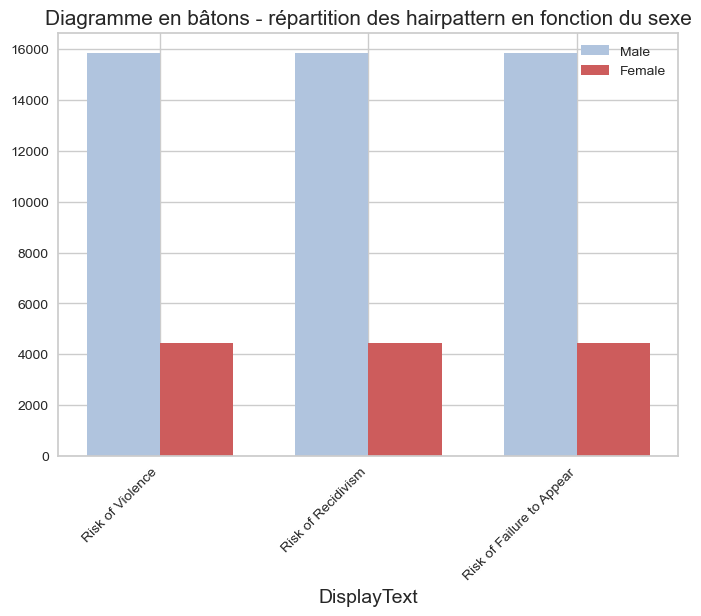

In [24]:
# Création du groupe "sex", et décompte des individus de chaque sous-grouê (male, female)
g = compas_scores_raw.groupby('Sex_Code_Text')
c_female = g.get_group('Female')['DisplayText'].value_counts()
c_male = g.get_group('Male')['DisplayText'].value_counts()

# On extrait les noms des différents hairpattern et des différents sexes
hairpat = compas_scores_raw['DisplayText'].value_counts().index
gender = compas_scores_raw['Sex_Code_Text'].value_counts().index
pos = np.arange(len(hairpat))
width = 0.35  # épaisseur de chaque bâton

# Création du diagramme en bâtons (bâtons côte à côte)
plt.bar(pos - width/2, c_male, width, color='lightsteelblue')
plt.bar(pos + width/2,c_female, width, color='IndianRed')
#plt.xticks(pos, hairpat)
plt.xticks(pos, hairpat, rotation=45, ha="right")

plt.xlabel('DisplayText', fontsize=14)
plt.title('Diagramme en bâtons - répartition des hairpattern en fonction du sexe',fontsize=15)
plt.legend(gender,loc=1)
plt.show()

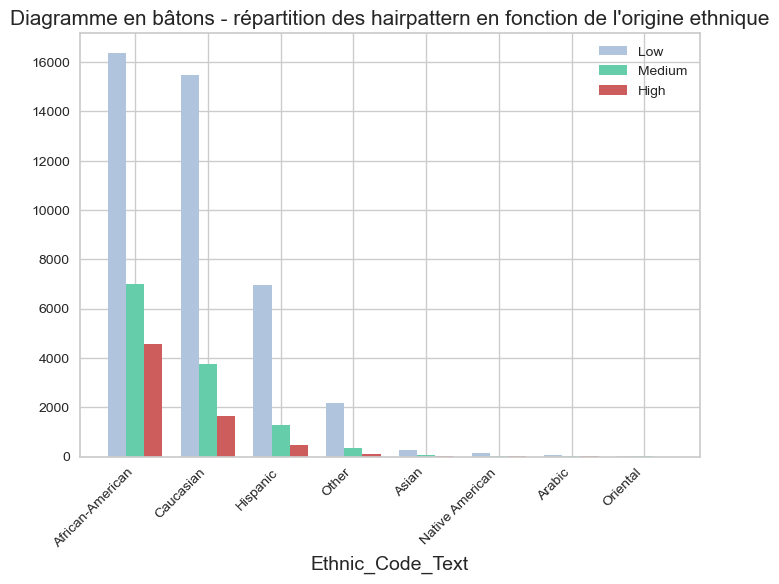

In [25]:
# Création du groupe "sex", et décompte des individus de chaque sous-groupe
g = compas_scores_raw.groupby('ScoreText')
c_0 = g.get_group('Low')['Ethnic_Code_Text'].value_counts()
c_1 = g.get_group('Medium')['Ethnic_Code_Text'].value_counts()
c_2 = g.get_group('High')['Ethnic_Code_Text'].value_counts()

# On extrait les noms des différents hairpattern et des différents groupes ethniques
hairpat = compas_scores_raw['Ethnic_Code_Text'].value_counts().index
ethnicity = compas_scores_raw['ScoreText'].value_counts().index
pos = np.arange(len(hairpat))
width = 0.25  # épaisseur de chaque bâton

# Création du diagramme en bâtons (bâtons côte à côte)
plt.bar(pos - width, c_0, width, color='lightsteelblue')
plt.bar(pos, c_1, width, color='mediumaquamarine')
plt.bar(pos + width, c_2, width, color='IndianRed')
#plt.xticks(pos, hairpat)
plt.xticks(pos, hairpat, rotation=45, ha="right")

plt.xlabel('Ethnic_Code_Text', fontsize=14)
plt.title('Diagramme en bâtons - répartition des hairpattern en fonction de l\'origine ethnique',fontsize=15)
plt.legend(ethnicity,loc=1)
plt.show()
